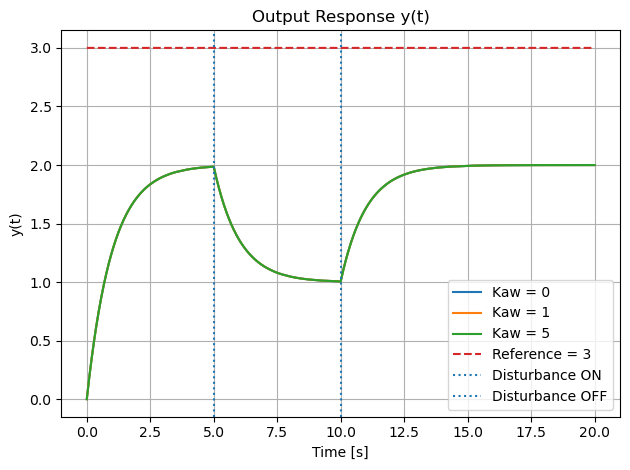

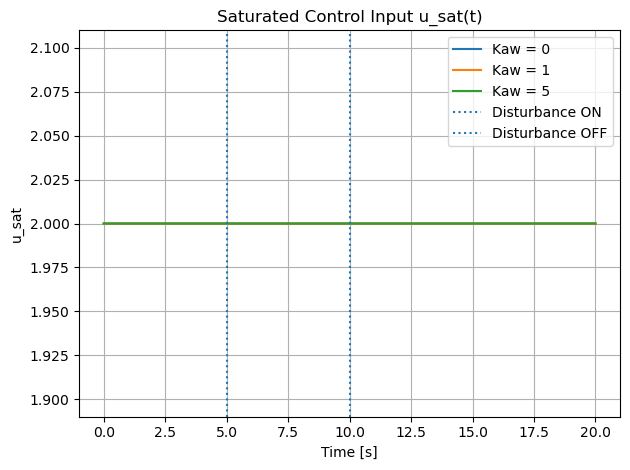

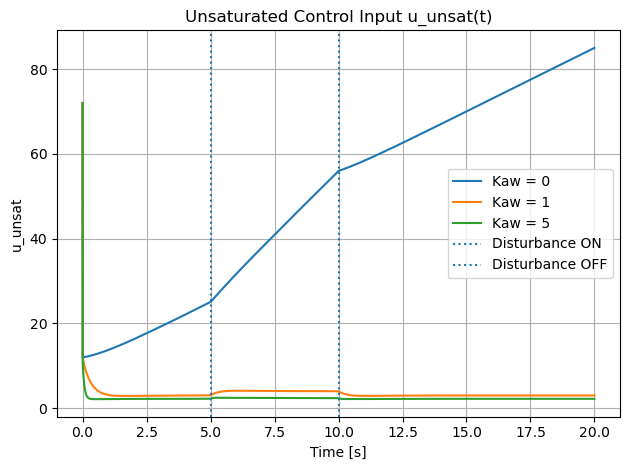

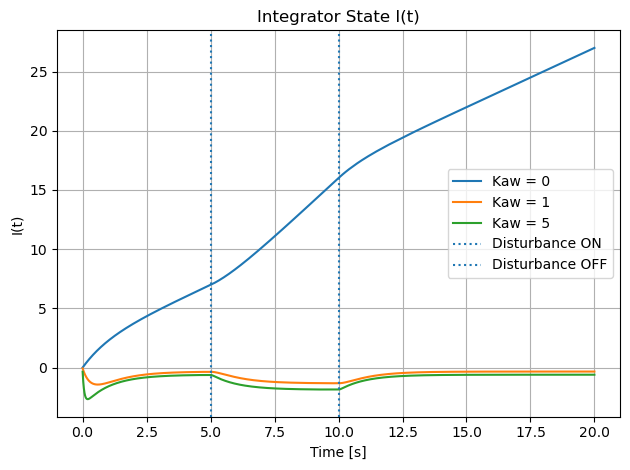

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read files
kaw_values = [0, 1, 5]
files = {
    kaw: f"pid_log_ref3_lim2_dis1_kaw{kaw}.csv"
    for kaw in kaw_values
}

data = {
    kaw: pd.read_csv(filename)
    for kaw, filename in files.items()
}

t_on = 5.0
t_off = 10.0

# plot fucntion
def decorate(title, ylabel):
    plt.axvline(t_on, linestyle=":", linewidth=1.5, label="Disturbance ON")
    plt.axvline(t_off, linestyle=":", linewidth=1.5, label="Disturbance OFF")
    plt.xlabel("Time [s]")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

# Plot 1: Output y(t)
plt.figure()
for kaw, df in data.items():
    plt.plot(df["time"], df["output"], label=f"Kaw = {kaw}")

plt.plot(
    data[kaw_values[0]]["time"],
    data[kaw_values[0]]["reference"],
    "--",
    label="Reference = 3"
)

decorate("Output Response y(t)", "y(t)")
plt.show()

# Plot 2: Saturated control u_sat(t)
plt.figure()
for kaw, df in data.items():
    plt.plot(df["time"], df["u_sat"], label=f"Kaw = {kaw}")

decorate("Saturated Control Input u_sat(t)", "u_sat")
plt.show()

# Plot 3: Unsaturated control u_unsat(t) 
plt.figure()
for kaw, df in data.items():
    plt.plot(df["time"], df["u_unsat"], label=f"Kaw = {kaw}")

decorate("Unsaturated Control Input u_unsat(t)", "u_unsat")
plt.show()

# Plot 4: Integrator state I(t)  
plt.figure()
for kaw, df in data.items():
    plt.plot(df["time"], df["integrator"], label=f"Kaw = {kaw}")

decorate("Integrator State I(t)", "I(t)")
plt.show()


In [6]:
kaws = [0, 1, 5]
t_off = 10.0            # disturbance OFF time
y_target = 2.0          # saturation-limited steady-state after disturbance off
tol = 0.02 * abs(y_target)  # 2% band around target (±0.04 if target=2)
hold_time = 0.1         # must stay inside band for 0.1s

def recovery_time(df, t_off, y_target, tol, hold_time=0.1):
    post = df[df["time"] >= t_off].copy()
    t = post["time"].to_numpy()
    y = post["output"].to_numpy()

    if len(t) < 2:
        return None

    dt = float(df["time"].iloc[1] - df["time"].iloc[0])
    hold_n = max(1, int(hold_time / dt))

    within = (abs(y - y_target) <= tol)

    for i in range(0, len(within) - hold_n + 1):
        if within[i:i+hold_n].all():
            return float(t[i] - t_off)  # seconds after t_off

    return None

rows = []
for kaw in kaws:
    filename = f"pid_log_ref3_lim2_dis1_kaw{kaw}.csv"
    df = pd.read_csv(filename)

    rt = recovery_time(df, t_off, y_target, tol, hold_time)

    # optional extra metrics that help the report
    max_I = df["integrator"].abs().max() if "integrator" in df.columns else None
    max_u_unsat = df["u_unsat"].abs().max() if "u_unsat" in df.columns else None

    rows.append({
        "Kaw": kaw,
        "recovery_time_after_toff_s": rt,
        "max_abs_integrator": max_I,
        "max_abs_u_unsat": max_u_unsat,
    })

results = pd.DataFrame(rows)
print(f"Target after disturbance OFF: y={y_target}, tolerance=±{tol} ({tol/y_target*100:.1f}%), t_off={t_off}s")
print(results.to_string(index=False))

Target after disturbance OFF: y=2.0, tolerance=±0.04 (2.0%), t_off=10.0s
 Kaw  recovery_time_after_toff_s  max_abs_integrator  max_abs_u_unsat
   0                        3.21            27.00000           84.997
   1                        3.21             1.43210           72.000
   5                        3.21             2.66457           72.000
